In [2088]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2089]:
import numpy as np
import matplotlib.pyplot as plt


from neuron_population import NeuronPopulation
from connectome import Connectome
from overhead import Simulation

In [2090]:
dt = 0.1

In [2091]:
# Neuron population parameters
layer_distribution = [2, 10, 2]
n_layers = 3
neuron_types = ["TRN", "p23", "nb"]
n_neuron_types = len(neuron_types)
inhibitory = [False, False, True]
dist_layer1 = np.array([1, 0, 0])
dist_layer2 = np.array([0, 8, 0])
dist_layer3 = np.array([1, 0, 0])
neuron_distribution = [dist_layer1, dist_layer2, dist_layer3]
threshold_decay = np.exp(-dt / 5)
layer_distances = np.zeros((n_layers, n_layers))
# mm
layer_distances[0, 0] = 0.6
layer_distances[1, 1] = 0.6
layer_distances[2, 2] = 0.6
layer_distances[0, 1] = 5.0
layer_distances[1, 0] = 5.0
layer_distances[1, 2] = 5.0
layer_distances[2, 1] = 5.0
layer_distances[0, 2] = 10.0
layer_distances[2, 0] = 10.0

In [2092]:
neuron_pop = NeuronPopulation(
    layer_distribution,
    neuron_distribution,
    layer_distances,
    neuron_types,
    inhibitory,
    threshold_decay,
    threshold_mult=1.15
)

In [2093]:
# Connectome
max_synapses = 10
synapse_strength = np.ones((n_layers, n_layers))
# neuron_types = ["p23", "TRN", "b", "nb"]
connectivity_probability = np.ones((n_layers, n_layers, n_neuron_types, n_neuron_types+2))


connectivity_probability[:,:,:,-2] = 0.0  # Self connections
connectivity_probability[:,:,:,-1] = 0.0  # No empty connections
# No inter-connections for input and output layers
connectivity_probability[0, 0, :, :-2] = 0
connectivity_probability[2, 2, :, :-2] = 0
# Only flow in one direction
connectivity_probability[1, 0, :, :-2] = 0.0
connectivity_probability[2, 1, :, :-2] = 0.0
connectivity_probability[2, 0, :, :-2] = 0.0
# No jump from input to output
connectivity_probability[0, 2, :, :-2] = 0.0

In [2094]:
connectome = Connectome(
    max_synapses,
    neuron_pop,
    connectivity_probability,
    synapse_strength,
)

In [2095]:
connectome.M

array([[ 7,  8,  3,  3, 10,  9,  6, 11,  8, 10],
       [ 9, 11,  3,  3,  6,  6, 10,  2, 10,  5],
       [13, 12,  3,  9,  6,  5,  7, 10, 11, 10],
       [ 5,  4,  4, 10,  9, 11, 12,  8, 13,  4],
       [ 5,  3,  2,  7,  3, 10, 13,  9, 11,  6],
       [ 6,  7, 11, 13,  6,  4,  4, 13, 11, 12],
       [12,  2, 11,  3, 12,  7, 12,  8,  2, 10],
       [10,  6, 10,  6,  8, 12, 13,  4, 12, 13],
       [11, 12, 11,  5,  6,  7,  5, 11, 10,  9],
       [ 3, 13, 11,  8, 10, 10,  2,  5, 11, 10],
       [ 5,  7,  5,  5,  4,  2,  7,  8, 12, 12],
       [ 7,  6,  3,  6, 13,  7,  5,  4,  5,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [2096]:
# connectome.distances

In [2097]:
sim = Simulation(connectome, dt, stepper_type="adapt")
sim.plasticity.mirror_neurons = [(0, -2), (1, -1)]

In [2098]:
weights_t0 = connectome.W.copy()

In [2099]:
# connectome.W.copy()

In [2100]:
I_ext = np.zeros((neuron_pop.n_neurons))
I_ext[1] = 100
I_ext[2:-2] = 50

# I_ext = 100

for i in range(50000):
    sim.step(I_ext=I_ext)
    # print(sim.synapse_dynamics.g_ST)
    # if np.sum(sim.pre_spikes) > 0:
        # print(f"Step {i}, {sim.t_now}, heap size: {(sim.axonal_dynamics._heap)}")
        # print(sim.pre_spikes)

weights_t1 = connectome.W.copy()

In [2101]:
sim.plasticity.activity_trace

array([0.05543664, 1.41767135, 0.20748153, 0.19029379, 0.10358808,
       0.1955977 , 0.09734609, 0.07481483, 0.0713814 , 0.17814214,
       0.12406663, 0.0745973 , 0.05543664, 1.41767135])

In [2102]:
# sim.synapse_dynamics.g_GABA_B

In [2103]:
neuron_pop.inhibitory_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [2104]:
sim.neuron_states.V

array([-60.98143863, -65.66313361, -58.49416199, -58.40486647,
       -60.21883679, -57.59627495, -57.21121717, -58.69184185,
       -57.00256493, -58.70025541, -58.12725681, -57.34974516,
       -61.31509565, -65.84160534])

In [2105]:
weights_t1 # [neuron_pop.inhibitory_mask]

array([[0.05331952, 0.14760864, 0.03680351, 0.04048153, 0.13359076,
        0.17255722, 0.14058363, 0.08980576, 0.02585362, 0.05401667],
       [0.05136591, 0.00915443, 0.01606856, 0.07051481, 0.02833419,
        0.00517863, 0.02005091, 0.10144375, 0.01938175, 0.08408276],
       [1.85990132, 0.04656421, 0.08517678, 0.17809822, 0.03628304,
        0.0673245 , 0.04031383, 0.04827051, 0.10340378, 0.05337642],
       [0.07224188, 0.04817337, 0.05000318, 0.06991074, 0.16894959,
        0.04659249, 0.07036399, 0.11760193, 1.55576469, 0.12832554],
       [0.07660146, 0.17881726, 0.11201248, 0.13546295, 0.04756022,
        0.        , 0.55319323, 0.16648969, 0.07045931, 0.07379401],
       [0.12447366, 0.10162189, 0.05490804, 0.12688655, 0.04914898,
        0.09578842, 0.05968905, 0.51189838, 0.0064972 , 0.03909801],
       [0.03908192, 0.12080422, 0.04739777, 0.06171408, 0.04900955,
        0.13303468, 0.06546547, 0.1057407 , 0.19502468, 0.04521181],
       [0.0315054 , 0.07215395, 0.0538484

In [2106]:
weights_t1 -   weights_t0

array([[-0.71732395, -0.47530094, -0.31633798, -0.34795171, -2.08471727,
        -0.85553595, -1.77211578, -1.08913837, -0.08324886, -0.84294358],
       [-0.37101789, -0.29625377, -0.26675457, -1.17061774, -0.78703564,
        -0.14384627, -0.75194758, -1.1649484 , -0.72685306, -1.99151641],
       [ 0.33256238, -0.88358252, -0.81099986, -0.94245767, -0.51237905,
        -1.00016794, -0.5892524 , -0.85155011, -1.43082131, -0.94162458],
       [-1.07362155, -0.59740452, -0.62009634, -1.23721077, -0.89990074,
        -0.64441175, -1.3379635 , -0.4100053 ,  0.29952177, -1.59138262],
       [-1.09977859, -1.63060144, -0.77771017, -1.89286017, -0.43369281,
         0.        , -0.14946649, -0.86470777, -0.90467659, -0.98575105],
       [-1.75641597, -1.48491547, -0.75959334,  0.02347584, -0.69352867,
        -1.18717704, -0.73977074,  0.09470859, -0.08988171, -0.7425034 ],
       [-0.70937757, -0.8446332 , -0.61967462, -0.56915067, -0.88957439,
        -1.878171  , -1.18826662, -0.35696105

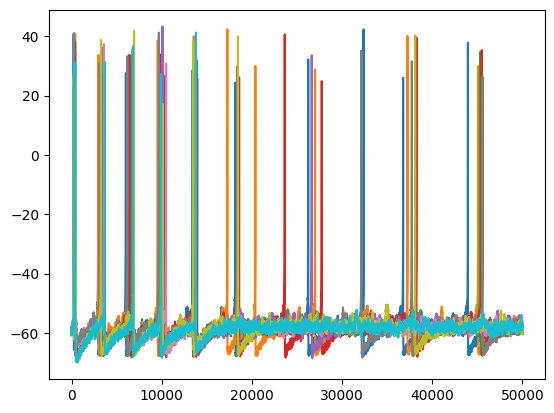

In [2107]:
plt.plot(np.array(sim.stats.Vs)[:, neuron_pop.get_neurons_from_layer(1)])
plt.show()

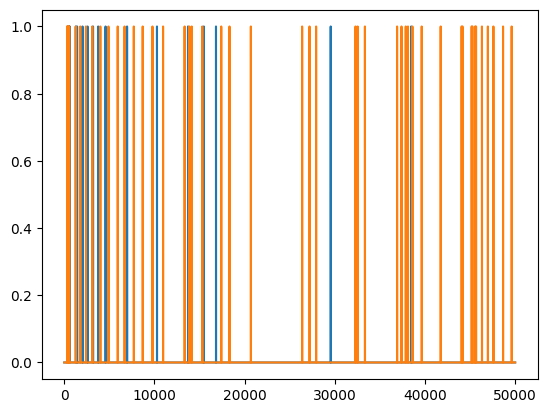

In [2108]:
plt.plot(np.array(sim.stats.spikes)[:, neuron_pop.get_neurons_from_layer(2)])
plt.show()